In [47]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,classification_report
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')

In [48]:
train_dir = '../input/dog-breed-identification/train'
train_size = len(os.listdir('../input/dog-breed-identification/train'))

train_size

10222

In [49]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cuda'

In [50]:
df = pd.read_csv('../input/dog-breed-identification/labels.csv')


In [73]:
labels = sorted(df['breed'].unique())
n_classes = len(labels)
labels

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [52]:
class_to_num = dict(zip(labels,np.arange(n_classes)))


In [53]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('breed', axis = 1), df['breed'], test_size=0.2, random_state=42)

In [54]:
X_train['breed'] = y_train
X_test['breed'] = y_test

In [55]:
import os
import numpy as np
from PIL import Image

In [56]:
img = Image.open(os.path.join(train_dir, df['id'][0] + '.jpg'))
original_mode = img.mode
print(f"The original color format (mode) of the image is: {original_mode}")

The original color format (mode) of the image is: RGB


In [ ]:

img_size = (224,224,3)

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class DogBreedDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        label = self.labels[index]

        # Load image
        image = Image.open(img_path)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Convert label to numerical format
        label_num = class_to_num[label]

        return image, label_num

In [ ]:
transform = transforms.Compose([
    transforms.Resize((img_size[0], img_size[1])),
    transforms.ToTensor(),  # Converts image to [0,1] float tensor
])

# Create the datasets
# We will use the paths and labels generated by the previous images_to_tensor function call

def get_image_paths_and_labels(data_dir, df):
    image_names = list(df['id'])
    image_labels = list(df['breed'])
    image_paths = [os.path.join(data_dir, img_name + '.jpg') for img_name in image_names]
    return image_paths, image_labels

train_image_paths, train_labels_list = get_image_paths_and_labels(train_dir, X_train)
test_image_paths, test_labels_list = get_image_paths_and_labels(train_dir, X_test)


train_dataset = DogBreedDataset(train_image_paths, train_labels_list, transform=transform)
test_dataset = DogBreedDataset(test_image_paths, test_labels_list, transform=transform)

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

Train Dataset Size: 8177
Test Dataset Size: 2045


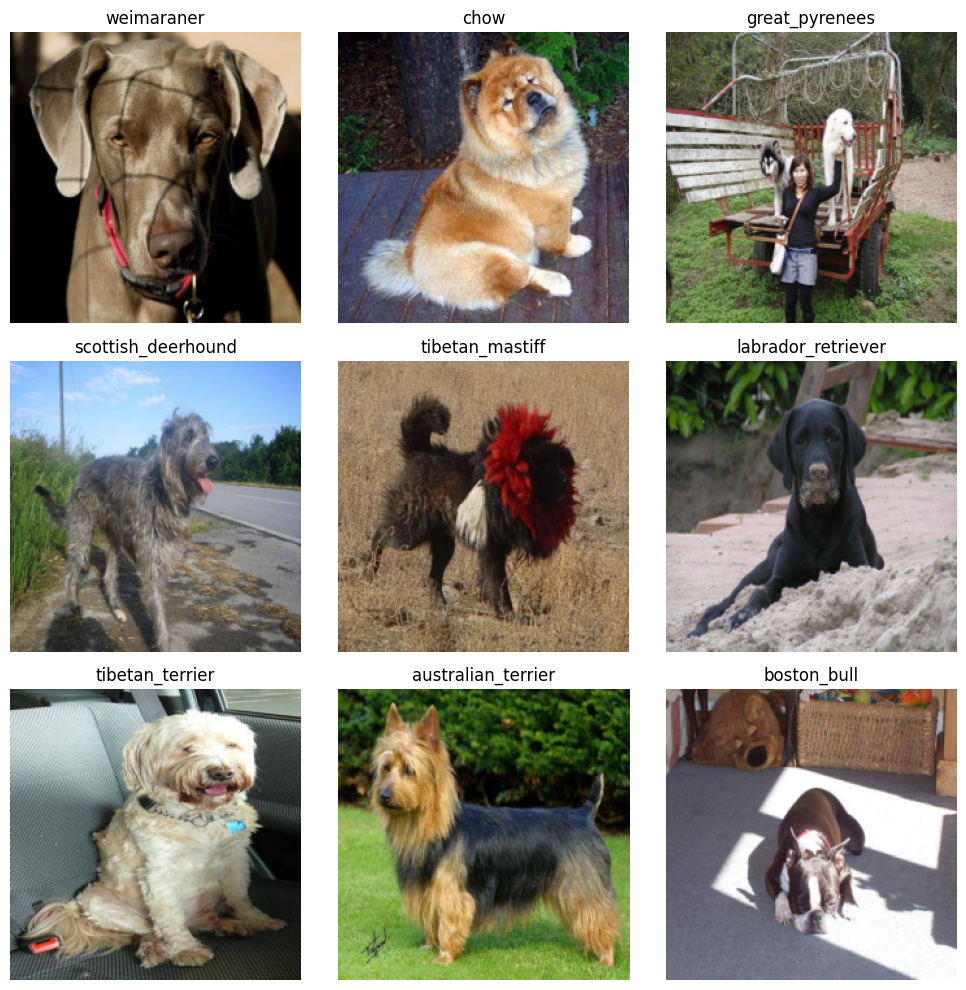

In [60]:
num_samples_to_plot = 9  # You can change this number
indices_to_plot = np.random.choice(len(train_dataset), num_samples_to_plot, replace=False)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(indices_to_plot):
    image, label_num = train_dataset[idx]

    # Convert the tensor image to a format suitable for plotting (HxWx channels)
    # and move it to CPU if it's on GPU
    image_np = image.permute(1, 2, 0).cpu().numpy()

    # Find the breed name from the label number
    breed_name = labels[label_num]

    plt.subplot(3, 3, i + 1)
    plt.imshow(image_np)
    plt.title(breed_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [61]:
from torch.utils.data import DataLoader

# Create DataLoaders for the train and test data
batch_size = 64 # You can adjust this based on your GPU memory
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of batches in train_dataloader: {len(train_dataloader)}")
print(f"Number of batches in test_dataloader: {len(test_dataloader)}")


Number of batches in train_dataloader: 128
Number of batches in test_dataloader: 32


In [62]:
from torchvision.models import resnet18
model = models.resnet18(pretrained=True)
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), 
                             lr=0.001)

In [ ]:
torch.manual_seed(42)

# Measure time
from tqdm.auto import tqdm
import time

# Train and test model
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Training loop
epochs = 15
train_loss_list = []
train_accuracy_list = []
test_loss_list= []
test_accuracy_list= []

start_time = time.time()

for epoch in tqdm(range(epochs)):
    ### Training
    model.train() # set model to training mode
    train_loss = 0
    train_acc = 0
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred_logits = model(X)

        loss = loss_fn(y_pred_logits,y) 

        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        y_pred_prob = torch.softmax(y_pred_logits, dim=1)
        y_pred = torch.argmax(y_pred_prob, dim=1)
        train_acc += accuracy_fn(y_pred, y)


    # Calculate average train loss and accuracy
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_acc)


    ### Testing
    model.eval() # set model to evaluation mode
    test_loss = 0
    test_acc = 0
    with torch.no_grad():
        for X,y in test_dataloader:
            X,y = X.to(device), y.to(device)

            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y) # Calculate loss on test data
            test_loss += loss.item()

            test_pred_prob = torch.softmax(test_pred_logits, dim=1)
            test_pred = torch.argmax(test_pred_prob, dim=1)
            acc = accuracy_fn(y,test_pred) # Calculate accuracy on test data
            test_acc += acc

    # Calculate average loss and accuracy for the epoch
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_acc)


    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 3.64008 | Train acc: 20.46% | Test loss: 2.99388 | Test acc: 26.17%
Epoch: 2 | Train loss: 1.88286 | Train acc: 47.86% | Test loss: 2.87381 | Test acc: 32.82%
Epoch: 3 | Train loss: 1.10620 | Train acc: 67.65% | Test loss: 5.38960 | Test acc: 17.21%
Epoch: 4 | Train loss: 0.64806 | Train acc: 80.27% | Test loss: 3.49237 | Test acc: 28.21%
Epoch: 5 | Train loss: 0.39223 | Train acc: 88.33% | Test loss: 2.39304 | Test acc: 43.82%
Epoch: 6 | Train loss: 0.21219 | Train acc: 93.75% | Test loss: 2.41816 | Test acc: 44.58%
Epoch: 7 | Train loss: 0.11778 | Train acc: 96.91% | Test loss: 2.36386 | Test acc: 47.23%
Epoch: 8 | Train loss: 0.06557 | Train acc: 98.60% | Test loss: 2.43820 | Test acc: 47.77%
Epoch: 9 | Train loss: 0.05224 | Train acc: 98.79% | Test loss: 2.54237 | Test acc: 45.17%
Epoch: 10 | Train loss: 0.05724 | Train acc: 98.76% | Test loss: 2.69935 | Test acc: 42.43%
Epoch: 11 | Train loss: 0.26490 | Train acc: 92.37% | Test loss: 3.86130 | Test acc: 31.1

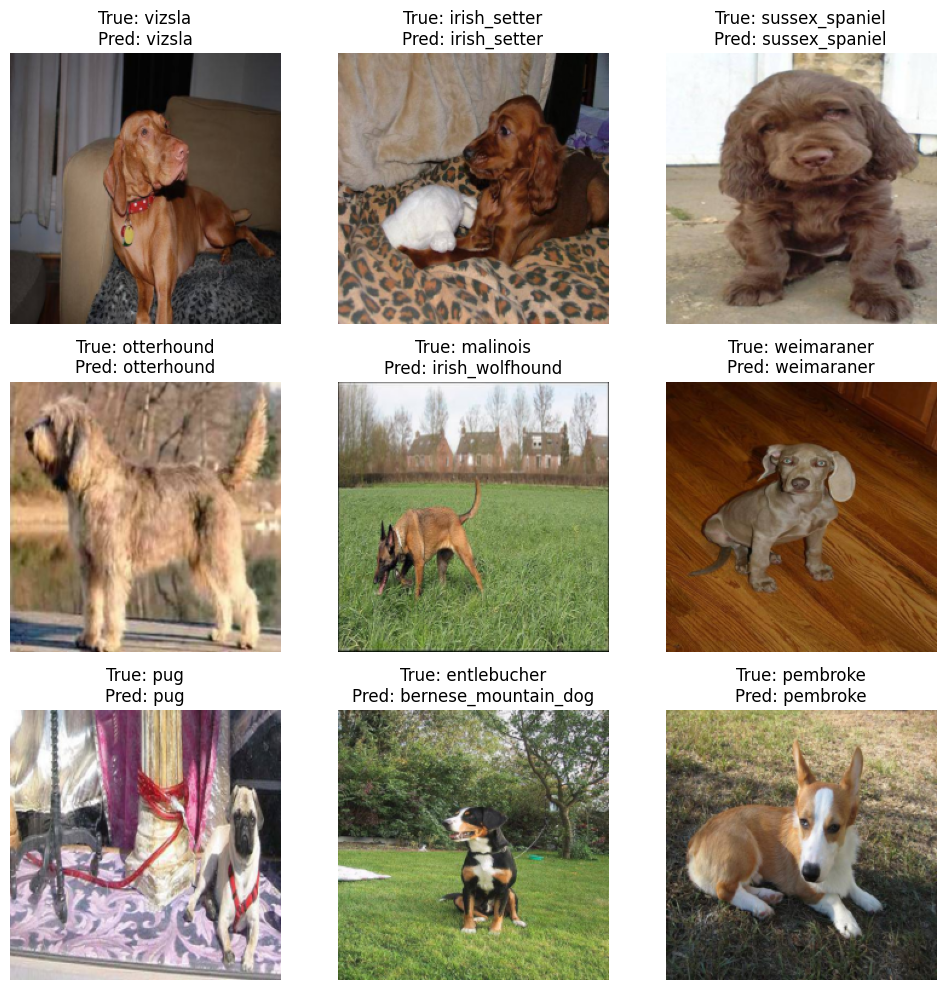

In [ ]:
samples = 9  
indices_to_plot = np.random.choice(len(test_dataset), samples, replace=False)

plt.figure(figsize=(10, 10))
model.eval()  
with torch.no_grad():
    for i, idx in enumerate(indices_to_plot):
        image, true_label_num = test_dataset[idx]
        image = image.to(device).unsqueeze(0)  

        output = model(image)
        predicted_label_num = torch.argmax(output, dim=1).item()
        
        image_np = image.squeeze(0).permute(1, 2, 0).cpu().numpy()

      
        true_breed_name = labels[true_label_num]
        predicted_breed_name = labels[predicted_label_num]

        plt.subplot(3, 3, i + 1)
        plt.imshow(image_np)
        plt.title(f"True: {true_breed_name}\nPred: {predicted_breed_name}")
        plt.axis('off')

plt.tight_layout()
plt.show()

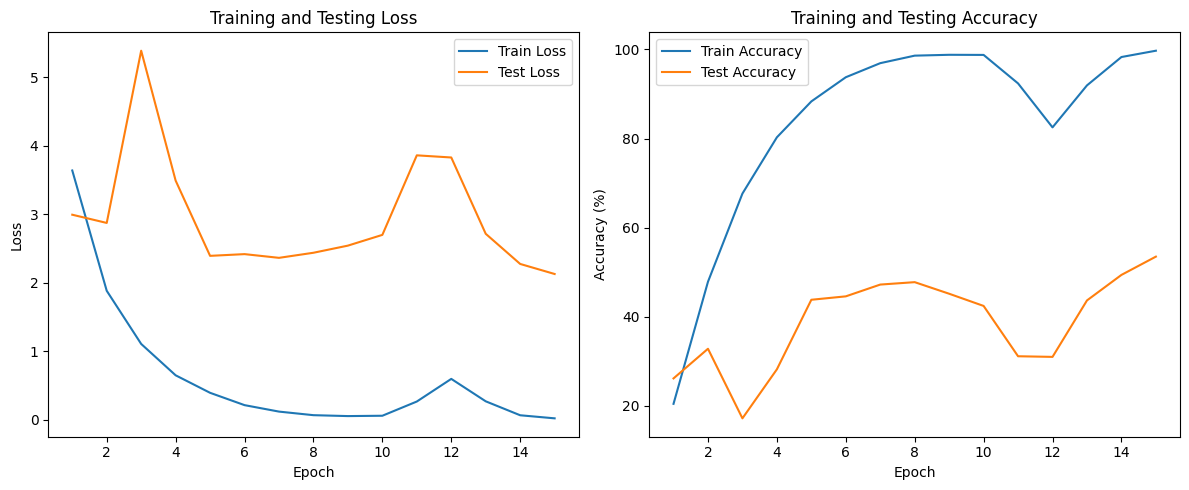

In [77]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss_list, label='Train Loss')
plt.plot(range(1, epochs + 1), test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracy_list, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Testing Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [78]:
class PredictionDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]

        # Load image
        image = Image.open(img_path) # Ensure image is in RGB

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image

In [79]:
test_dir = '../input/dog-breed-identification/test'
test_size = len(os.listdir('../input/dog-breed-identification/test'))

test_size

10357

In [80]:
test_image_names = os.listdir(test_dir)
test_image_paths = [os.path.join(test_dir, img_name) for img_name in test_image_names]

prediction_dataset = PredictionDataset(test_image_paths, transform=transform)
batch_size = 64 
testset = DataLoader(prediction_dataset, batch_size=batch_size, shuffle=False) # No need to shuffle for prediction

print(f"Number of samples in prediction dataset: {len(prediction_dataset)}")
print(f"Number of batches in prediction_dataloader: {len(testset)}")

Number of samples in prediction dataset: 10357
Number of batches in prediction_dataloader: 162


In [ ]:
model.eval()

predictions = []
image_ids = [img_name.split('.')[0] for img_name in test_image_names] 

with torch.no_grad():
    for images in testset:
        images = images.to(device)

        # Forward pass
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)

        # Append predictions to the list
        predictions.append(probabilities.cpu().numpy())

# Concatenate predictions from all batches
predictions = np.concatenate(predictions)

print(f"Shape of predictions array: {predictions.shape}")

In [ ]:
predicted_class_indices = np.argmax(predictions, axis=1)


predicted_labels = [labels[i] for i in predicted_class_indices]

print(f"Number of predicted labels: {len(predicted_labels)}")
print(f"First 10 predicted labels: {predicted_labels[:10]}")

In [ ]:
submission_df = pd.DataFrame({'id': image_ids, 'breed': predicted_labels})

submission_df.to_csv('submission.csv', index=False)
display(submission_df.head())

In [76]:
PATH = "model_state_dict.pt"

# Save the model's state dictionary
torch.save(model.state_dict(), PATH)